# 3.8 多层感知机（multilayer perceptron,MLP）

## 3.8.1 隐藏层

多层感知机在单层神经网络的基础上引入了一到多个隐藏层（hidden layer）。隐藏层位于输入层和输出层之间。图3.3展示了一个多层感知机的神经网络图，它含有一个隐藏层，该层中有5个隐藏单元。

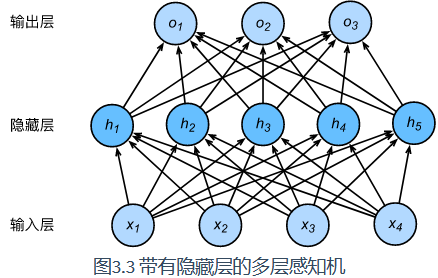

在图3.3所示的多层感知机中，输入和输出个数分别为4和3，中间的隐藏层中包含了5个隐藏单元（hidden unit）。由于输入层不涉及计算，图3.3中的多层感知机的层数为2。由图3.3可见，隐藏层中的神经元和输入层中各个输入完全连接，输出层中的神经元和隐藏层中的各个神经元也完全连接。因此，多层感知机中的隐藏层和输出层都是全连接层。

具体来说，给定一个小批量样本$X\in \mathbb{R}^{n\times d}$，其批量大小为$n$，输入个数为$d$。假设多层感知机只有一个隐藏层，其中隐藏单元个数为$h$。记隐藏层的输出（也称为隐藏层变量或隐藏变量）为$H$,有$H \in \mathbb{R}^{n\times h}$。因为隐藏层和输出层均是全连接层，可以设隐藏层的权重参数和偏差参数分别为$W_h \in \mathbb{R}^{d\times h}$和$b_h \in \mathbb{R}^{1\times h}$，输出层的权重和偏差参数分别为$W_o \in \mathbb{R}^{h\times q}$和$b_o \in \mathbb{R}^{1\times q}$。

我们先来看一种含单隐藏层的多层感知机的设计。其输出$O \in \mathbb{R}^{n\times q}$的计算为
$$H=X W_h+b_h,$$
$$O=H W_o+b_o,$$

也就是将隐藏层的输出直接作为输出层的输入。如果将以上两个式子联立起来，可以得到
$$O=(X W_h+b_h)W_o+b_o=X W_h W_o+b_h W_o+b_o$$

从联立后的式子可以看出，虽然神经网络引入了隐藏层，却依然等价于一个单层神经网络：其中输出层权重参数为$W_h W_o$,偏差参数为$b_h W_o+b_o$。不难发现，即便再添加更多的隐藏层，以上设计依然只能与仅含输出层的单层神经网络等价。

## 3.8.2 激活函数

上述问题的根源在于全连接层只是对数据做仿射变换--线性变换（affine transformation），而多个仿射变换的叠加仍然是一个仿射变换，不能解决线性不可分的问题。解决问题的一个方法是引入非线性变换，例如对隐藏变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数被称为激活函数（activation function）。

### 3.8.2.1 ReLU函数

ReLU（rectified linear unit）函数提供了一个很简单的非线性变换。ReLU函数只保留整数元素，并将负数元素清零。

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

def xyplot(x_vals,y_vals,name):
    d2l.set_figsize(figsize=(5,2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

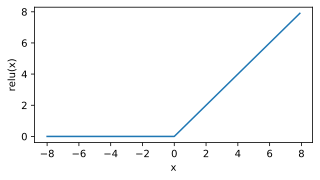

In [2]:
x=torch.arange(-8.0,8.0,0.1,requires_grad=True)
y=x.relu()
xyplot(x,y,'relu')

显然，当输入为负数时，ReLU函数的导数为0；当输入为正数时，ReLU函数的导数为1。尽管输入为0时ReLU函数不可导，但是我们可以取此处的导数为0。下面绘制ReLU函数的导数。

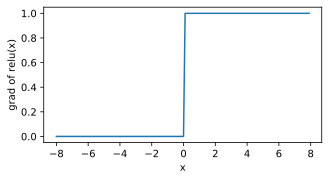

In [3]:
y.sum().backward()
xyplot(x,x.grad,'grad of relu')

### 3.8.2.2 sigmoid函数

$$sigmoid(x)=\frac{1}{1+exp(-x)}$$

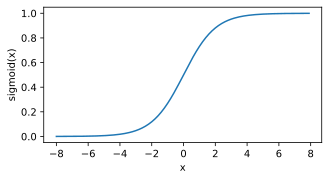

In [4]:
y=x.sigmoid()
xyplot(x,y,'sigmoid')

依据链式法则，sigmoid函数的导数

$$sigmoid'(x)=sigmoid(x)(1−sigmoid(x))$$.

下面绘制了sigmoid函数的导数。当输入为0时，sigmoid函数的导数达到最大值0.25；当输入越偏离0时，sigmoid函数的导数越接近0。

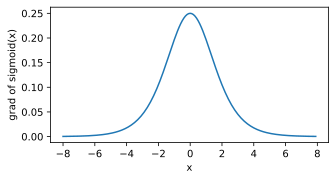

In [5]:
x.grad.zero_()
y.sum().backward()
xyplot(x,x.grad,'grad of sigmoid')

### 3.8.2.3 tanh函数

tanh(双曲正切)函数将元素值变换到-1到1之间：

$$tanh(x)=\frac{1-exp(-2x)}{1+exp(-2x)}$$

<font color='red'>当输入接近0时，tanh函数接近线性变换，tanh函数在坐标系原点对称。</font>

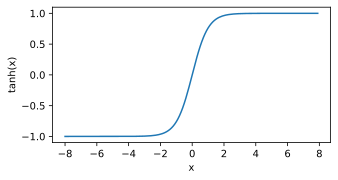

In [6]:
y=x.tanh()
xyplot(x,y,'tanh')

tanh函数的导数：$tanh'(x)=1-tanh^{2}(x)$

当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数接近0

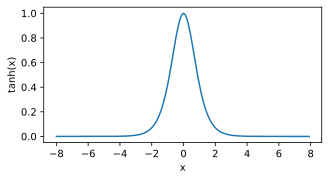

In [7]:
x.grad.zero_()
y.sum().backward()
xyplot(x,x.grad,'tanh')

### 3.8.3 多层感知机

多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。以单隐藏层为例并沿用本节之前定义的符号，多层感知机按以下方式计算输出：

$$H=\phi (X W_h+b_h)$$
$$O=H W_o+b_o$$

其中$\phi $表示激活函数。在分类问题中，我们可以对输出$O$做$softmax$运算，并使用$softmax$回归中的交叉熵损失函数。 在回归问题中，我们将输出层的输出个数设为1，并将输出$O$直接提供给线性回归中使用的平方损失函数。